In [1]:
from pathlib import Path
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import pickle
import math
import matplotlib.pyplot as plt

In [43]:
## Define the dir

base_dir = Path('/mnt/data/dino_sam/voc')
dinov2_last_feat_dir = base_dir / 'features' / 'dinov2_last_4'
dinov1_last_two_dir = base_dir / 'features' / 'dinov1_last_2'
img_dir = base_dir / 'JPEGImages/'

In [44]:

file_name = '2008_001119'
img_file = img_dir / f'{file_name}.jpg'
dinov2_last_feats_file = dinov2_last_feat_dir / f'{file_name}.pkl'
dinov1_last_feats_file = dinov1_last_two_dir / f'{file_name}.pkl'

with open(dinov2_last_feats_file, 'rb') as f:
    dinov2_last_feats = pickle.load(f)
with open(dinov1_last_feats_file, 'rb') as f:
    dinov1_last_feats = pickle.load(f)
img = Image.open(img_file)
img = T.ToTensor()(img).unsqueeze(0)


In [45]:
dinov1_last_feats.shape, dinov2_last_feats.shape, img.shape

((1, 1536, 47, 63), (1, 4096, 27, 36), torch.Size([1, 3, 375, 500]))

In [46]:

length_1 = 8
length_2 = 14

H1, W1 = length_1 * math.ceil(img.shape[-2] / length_1), length_1 * math.ceil(img.shape[-1] / length_1)
H2, W2 = length_2 * math.ceil(img.shape[-2] / length_2), length_2 * math.ceil(img.shape[-1] / length_2)

H, W = img.shape[-2], img.shape[-1]

In [47]:
print(H1, W1, H2, W2)

376 504 378 504


In [48]:

center_cropping = T.CenterCrop((H, W))

In [49]:

dino1_upsampled = F.interpolate(torch.tensor(dinov1_last_feats), size=(H1, W1), mode='bilinear', align_corners=False)
dino2_upsampled = F.interpolate(torch.tensor(dinov2_last_feats), size=(H2, W2), mode='bilinear', align_corners=False)

dino1 = center_cropping(dino1_upsampled)
dino2 = center_cropping(dino2_upsampled)

In [50]:
dino1.shape, dino2.shape

(torch.Size([1, 1536, 375, 500]), torch.Size([1, 4096, 375, 500]))

In [51]:
## Apply PCA

from sklearn.decomposition import PCA
import numpy as np


In [52]:
PCA1 = PCA(n_components=3)
PCA2 = PCA(n_components=3)

dino1 = dino1[0].permute(1, 2, 0).reshape(H * W, -1).numpy()
dino2 = dino2[0].permute(1, 2, 0).reshape(H * W, -1).numpy()

PCA1.fit(dino1)
PCA2.fit(dino2)

dino1_pca = PCA1.transform(dino1)
dino2_pca = PCA2.transform(dino2)



In [53]:
dino1.shape, dino1_pca.shape

((187500, 1536), (187500, 3))

In [54]:
pca_vis_1 = (dino1_pca - dino1_pca.min(axis = -1)[..., None]) / \
                    (dino1_pca.max(axis = -1)[..., None] - dino1_pca.min(axis = -1)[..., None])
pca_vis_2 = (dino2_pca - dino2_pca.min(axis = -1)[..., None]) / \
                    (dino2_pca.max(axis = -1)[..., None] - dino2_pca.min(axis = -1)[..., None])


In [55]:
pca_vis_1 = pca_vis_1.reshape(H, W, 3)
pca_vis_2 = pca_vis_2.reshape(H, W, 3)


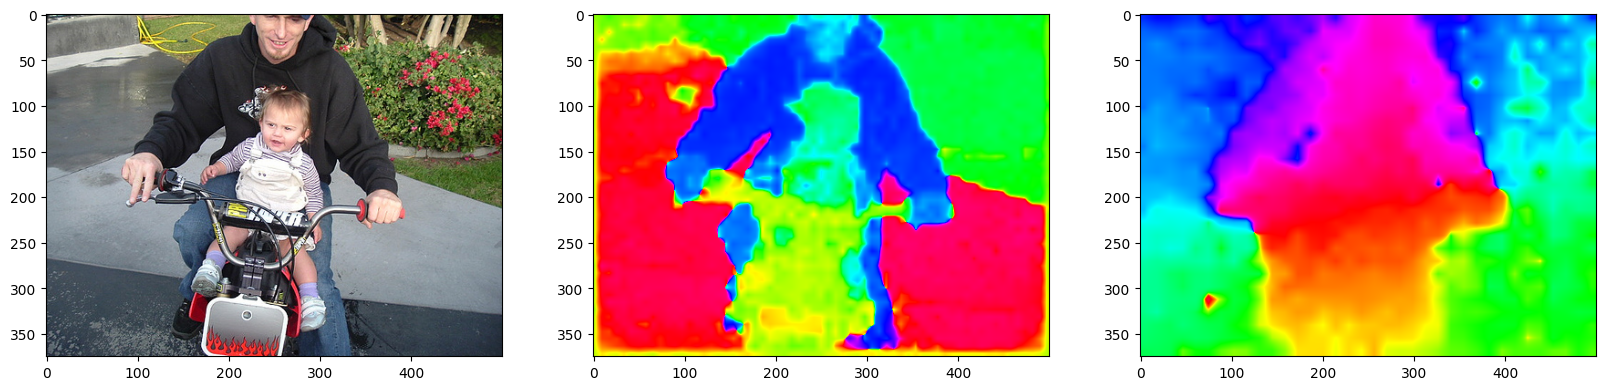

In [56]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(pca_vis_1)
plt.subplot(1, 3, 3)
plt.imshow(pca_vis_2)


In [57]:
dino1 = center_cropping(dino1_upsampled)
dino2 = center_cropping(dino2_upsampled)

PCA1 = PCA(n_components=3)
PCA2 = PCA(n_components=3)

dino1 = dino1[0].permute(1, 2, 0).reshape(H * W, -1).numpy()[:, -768:]
dino2 = dino2[0].permute(1, 2, 0).reshape(H * W, -1).numpy()[:, -1024:]

PCA1.fit(dino1)
PCA2.fit(dino2)

dino1_pca = PCA1.transform(dino1)
dino2_pca = PCA2.transform(dino2)

pca_vis_1 = (dino1_pca - dino1_pca.min(axis = -1)[..., None]) / \
                    (dino1_pca.max(axis = -1)[..., None] - dino1_pca.min(axis = -1)[..., None])
pca_vis_2 = (dino2_pca - dino2_pca.min(axis = -1)[..., None]) / \
                    (dino2_pca.max(axis = -1)[..., None] - dino2_pca.min(axis = -1)[..., None])
pca_vis_1 = pca_vis_1.reshape(H, W, 3)
pca_vis_2 = pca_vis_2.reshape(H, W, 3)


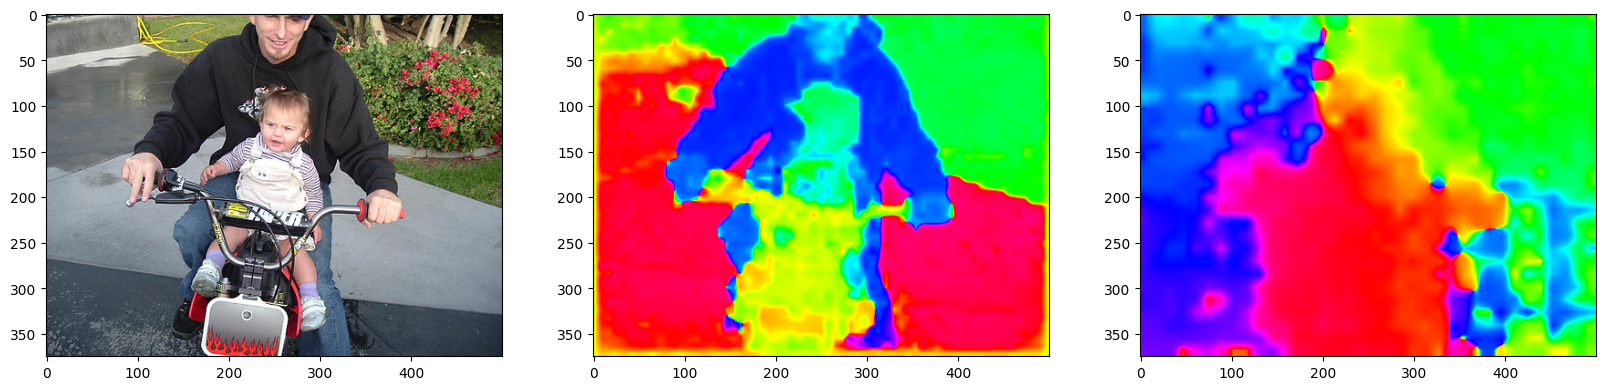

In [58]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(pca_vis_1)
plt.subplot(1, 3, 3)
plt.imshow(pca_vis_2)


# Test Dense CLIP

In [59]:
## Define the dir

base_dir = Path('/mnt/data/dino_sam/voc')
dense_clip_dir = base_dir / 'features' / 'dense_clip'
img_dir = base_dir / 'JPEGImages/'

file_name = '2008_001119'
img_file = img_dir / f'{file_name}.jpg'
dense_clip_file = dense_clip_dir / f'{file_name}.pkl'

with open(dense_clip_file, 'rb') as f:
    dense_clip_feats = pickle.load(f)
img = Image.open(img_file)
img = T.ToTensor()(img).unsqueeze(0)

dense_clip_upsampled = F.interpolate(torch.tensor(dense_clip_feats), size=(H2, W2), mode='bilinear', align_corners=False)

dense_clip = center_cropping(dense_clip_upsampled)

In [60]:
H2, W2

(378, 504)

In [65]:
dense_clip.shape

torch.Size([1, 768, 375, 500])

In [62]:
dense_clip.shape

torch.Size([1, 768, 375, 500])

In [63]:
H2, W2

(378, 504)

In [ ]:

dino1_upsampled = F.interpolate(torch.tensor(dinov1_last_feats), size=(H1, W1), mode='bilinear', align_corners=False)
dino2_upsampled = F.interpolate(torch.tensor(dinov2_last_feats), size=(H2, W2), mode='bilinear', align_corners=False)

dino1 = center_cropping(dino1_upsampled)
dino2 = center_cropping(dino2_upsampled)

In [64]:
from sklearn.cluster import KMeans
# feature_np = features.cpu()
# H, W = 490, 644
# ori_H, ori_W = 480, 640
features_np = dense_clip.cpu().permute(0, 2, 3, 1).reshape(H2 * W2, -1).numpy()
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_np)


RuntimeError: shape '[190512, -1]' is invalid for input of size 144000000